In [2]:
# Name:Ashish Sahu
# CodSoft Machine learning
# SPAM SMS DETECTION

# Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertModel

# Load the dataset

In [4]:
data = pd.read_csv('/content/sample_data/spam.csv', encoding='latin-1')

# Explore the dataset

In [5]:
print("Dataset shape:", data.shape)

Dataset shape: (5572, 5)


In [6]:
print("Dataset columns:", data.columns)

Dataset columns: Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


In [7]:
print("Dataset head:", data.head())

Dataset head:      v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


# Preprocessing

In [8]:
data['v1'] = data['v1'].map({'spam': 1, 'ham': 0})

## Split the data into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['v2'], data['v1'], test_size=0.2, random_state=42)

## TF-IDF Vectorization

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Classifier models

In [11]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9668161434977578
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

Naive Bayes Confusion Matrix:
[[965   0]
 [ 37 113]]


In [12]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)
y_pred_lr = lr_classifier.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9524663677130045
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115

Logistic Regression Confusion Matrix:
[[962   3]
 [ 50 100]]


In [13]:
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)
y_pred_svm = svm_classifier.predict(X_test_tfidf)
print("Support Vector Machine Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("Support Vector Machine Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Support Vector Machine Accuracy: 0.9766816143497757
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.99      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Support Vector Machine Confusion Matrix:
[[964   1]
 [ 25 125]]


# BERT Model

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
def tokenize_text(text):
  inputs = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=512,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
  )
  return inputs

In [16]:
X_train_bert = [tokenize_text(text) for text in X_train]
X_test_bert = [tokenize_text(text) for text in X_test]

In [17]:
train_features = []
test_features = []

In [18]:
for inputs in X_train_bert:
  outputs = model(**inputs)
  pooled_output = outputs.pooler_output
  train_features.append(pooled_output.detach().numpy())

In [19]:
for inputs in X_test_bert:
  outputs = model(**inputs)
  pooled_output = outputs.pooler_output
  test_features.append(pooled_output.detach().numpy())

In [20]:
train_features = np.array(train_features)
test_features = np.array(test_features)

In [21]:
bert_classifier = torch.nn.Linear(model.config.hidden_size, 2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_classifier.parameters(), lr=0.001)

In [22]:
for epoch in range(5):
  optimizer.zero_grad()
  outputs = model(**X_train_bert[0])
  pooled_output = outputs.pooler_output
  outputs = bert_classifier(pooled_output)
  loss = criterion(outputs, torch.tensor([y_train[0]]))
  loss.backward()
  optimizer.step()
  print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.700262188911438
Epoch 2, Loss: 0.3846808075904846
Epoch 3, Loss: 0.20132999122142792
Epoch 4, Loss: 0.10565727949142456
Epoch 5, Loss: 0.05752790719270706


In [23]:
y_pred_bert = []
with torch.no_grad():
  for text in X_test_bert:
    outputs = model(**text)
    pooled_output = outputs.pooler_output
    outputs = bert_classifier(pooled_output)
    _, predicted = torch.max(outputs, 1)
    y_pred_bert.extend(predicted.cpu().numpy())

In [24]:
print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))
print("BERT Classification Report:")
print(classification_report(y_test, y_pred_bert))
print("BERT Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bert))

BERT Accuracy: 0.8645739910313901
BERT Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       965
           1       0.00      0.00      0.00       150

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.86      0.80      1115

BERT Confusion Matrix:
[[964   1]
 [150   0]]


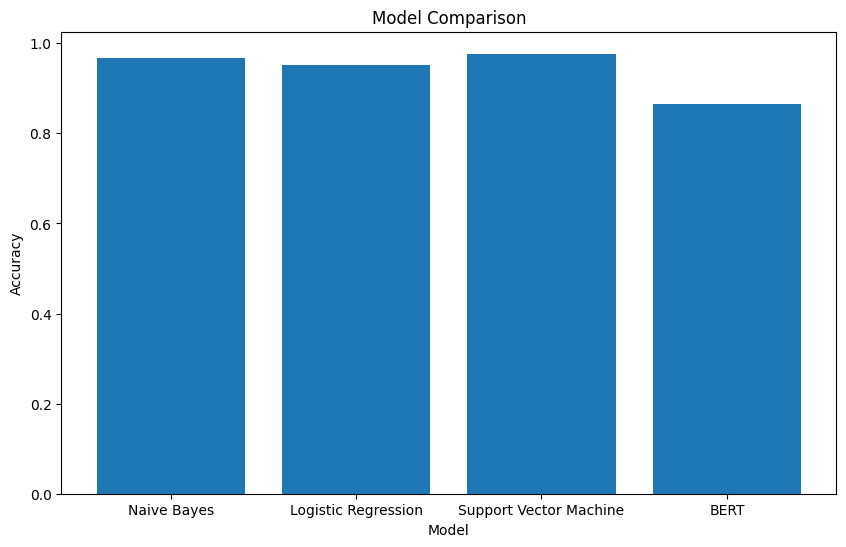

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(['Naive Bayes', 'Logistic Regression', 'Support Vector Machine', 'BERT'],
        [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_bert)])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


In [27]:
def is_message_spam(message, model, vectorizer):
    vectorized_message = vectorizer.transform([message])
    if model.predict(vectorized_message) == 1:
        print("Spam!!!")
    else:
        print("Not spam.")

In [28]:
is_message_spam("Congratulations! You've won a luxury vacation for two. Click the link to claim", nb_classifier, vectorizer)

Spam!!!


In [29]:
is_message_spam("Hello, Ata how are you.", nb_classifier, vectorizer)

Not spam.


In [30]:
is_message_spam("URGENT: Your bank account is locked. Reply with your login details to unlock.", nb_classifier, vectorizer)

Not spam.
